<a href="https://colab.research.google.com/github/rezabonyadi/autodecompose/blob/main/autodecompose_example_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jan 25 20:16:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install --upgrade --no-cache-dir gdown
# !pip install gdown

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
!mkdir ./data
!wget https://www.openslr.org/resources/12/train-clean-100.tar.gz -P ./data/
!tar -xf ./data/train-clean-100.tar.gz -C ./data/

# !wget https://www.openslr.org/resources/12/test-other.tar.gz -P ./data/
# !tar -xf ./data/test-other.tar.gz -C ./data/

--2023-01-25 20:16:27--  https://www.openslr.org/resources/12/train-clean-100.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6387309499 (5.9G) [application/x-gzip]
Saving to: ‘./data/train-clean-100.tar.gz’

train-clean-100.tar 100%[===================>]   5.95G  12.6MB/s    in 7m 48s  

2023-01-25 20:24:16 (13.0 MB/s) - ‘./data/train-clean-100.tar.gz’ saved [6387309499/6387309499]



In [6]:
import librosa
import librosa.display
import numpy as np
from matplotlib import pyplot as plt
import os, glob
path_audio = './data/LibriSpeech/train-clean-100/'
# path_audio = './data/LibriSpeech/test-other/'

In [26]:
from scipy.ndimage.morphology import binary_dilation
from pathlib import Path
from typing import Optional, Union
import numpy as np
# import webrtcvad
import librosa
import struct
import os
import pickle
import numpy as np
import soundfile as sf
from scipy import signal as sg
from scipy.signal import get_window
from librosa.filters import mel
from numpy.random import RandomState


def butter_highpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = sg.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a
    

def preprocess_wav(fpath_or_wav, setings):    
    # Load the wav from disk if needed
    if isinstance(fpath_or_wav, str) or isinstance(fpath_or_wav, Path):
        wav, source_sr = librosa.load(str(fpath_or_wav), sr=None)
    else:
        wav = fpath_or_wav
    
    # Resample the wav
    if source_sr!= setings['sampling_rate']:
        wav = librosa.resample(wav, source_sr, setings['sampling_rate'])
        
    return wav

def wav_to_mel_spectrogram(wav, settings):
    
    y = sg.filtfilt(settings['filter_b'], settings['filter_a'], wav)

    # Add a little random noise for model roubstness
    wav_filt = y * 0.96 + (np.random.rand(y.shape[0])-0.5)*1e-06

    frames = librosa.feature.melspectrogram(
        wav_filt,
        settings['sampling_rate'],
        n_fft=settings['n_fft'],
        hop_length=settings['hop_length'],
        n_mels=settings['mel_channels']
      ).astype(np.float32).T
    
    mel_db = librosa.power_to_db(frames, ref=1.0)
    mel = (mel_db + 100) / 200

    return mel


In [27]:
settings = {}

settings['fmin'] = 90
settings['fmax'] = 7600
settings['min_level'] = np.exp(-100 / 20 * np.log(10))

## Audio
settings['sampling_rate'] = 16000

# Preprocessing
settings['filter_order'] = 5
settings['filter_cutoff'] = 30

## mel
settings['n_fft'] = 256
settings['hop_length'] = 256
settings['fft_len'] = 256
settings['mel_channels'] = 80

settings['mel_basis'] = mel(settings['sampling_rate'], settings['n_fft'], fmin=settings['fmin'], fmax=settings['fmax'], 
                n_mels=settings['mel_channels']).T

settings['filter_b'], settings['filter_a'] = butter_highpass(settings['filter_cutoff'], settings['sampling_rate'], 
                                               order=settings['filter_order'])

# Breaking to partial utters
settings['len_crop'] = 64
settings['overlap'] = 0 # frames

# settings['results_folder'] = '/content/drive/My Drive/results/results_content_voice/'
settings['int16_max'] = (2 ** 15) - 1

In [33]:
def get_slices_indeces_mel(mel, slice_len, overlap, hop_length):
    mel_slices = [slice(*np.array([s, s+slice_len])) 
                  for s in range(0, mel.shape[0]-slice_len, slice_len-overlap)]
    
    wav_slices = [slice(*np.array([hop_length*s, hop_length*(s+slice_len)])) 
                  for s in range(0, mel.shape[0]-slice_len, slice_len-overlap)]
    return mel_slices, wav_slices

def prepare_split_data(filename, settings):
    wav = preprocess_wav(filename, settings)
    
    mel = wav_to_mel_spectrogram(wav, settings)
    mel_slices, wav_slices = get_slices_indeces_mel(mel, settings['len_crop'], 
                                                    settings['overlap'], settings['hop_length'])
    mels = [mel[s, :] for s in mel_slices]
    mels = np.array(mels)
    
    wavs = [wav[s] for s in wav_slices]
    wavs = np.array(wavs)

    return wavs, mels

def get_person_utterances(person_path):
  person_audio = os.listdir(person_path)
  all_wavs = []
  all_mels = []

  for f in person_audio:
      file_address = ''.join([person_path, f])
      utterances = os.listdir(file_address)
      
      for utterance in utterances:
          complete_address = (''.join([file_address, '/', utterance]))
          
          if complete_address[-4:] != 'flac':
              continue
              
          wavs, mels = prepare_split_data(complete_address, settings)
          all_mels.extend(mels)
          all_wavs.extend(wavs)
          
          
  return all_wavs, all_mels

In [34]:
# Use a specific set of people for consistency

# persons = [125, 7517, 233, 5049, 6078, 4195, 1040, 1841, 4406, 311, 7190, 2416, 118, 89, 458, 405, 322, 1867, 6209, 3259, 6529, 5163, 4051, 7178, 6081, 8797, 1235, 7148, 3947, 211]
persons = os.listdir(path_audio)
orig_data = []
wav_data = []
person_id = []

i = 0
for p in persons[:5]:
    print('Readin person: ', str(p))
    person_path = ''.join([path_audio, str(p), '/'])
    utterances_wav, utterances_mel = get_person_utterances(person_path)    
    orig_data.extend(utterances_mel)
    person_id.extend([i]*len(utterances_wav))
    # wav_data.extend(utterances_wav)
    i += 1
    

Readin person:  2691
Readin person:  2514
Readin person:  3664
Readin person:  403
Readin person:  8425


In [35]:
person_id = np.asarray(person_id)
orig_data = np.asarray(orig_data)
# wav_data = np.asarray(wav_data)

orig_data.shape

(7081, 64, 80)

In [36]:
import tensorflow as tf
from scipy.interpolate import interp1d, CubicSpline, make_interp_spline

def cut_along(y, number_of_manipulations=2, len_of_cut=5, axis=0, shift=10):
  # Cut a mel spectrum along the frequency or time domain
  new_mel = y
  
  s = number_of_manipulations
  for i in range(s):            
      p = 1+np.random.randint(0, len_of_cut) # Length to cut
      ind = shift+np.random.randint(0, new_mel.shape[axis]-len_of_cut) # Do not cut anything below 10 hz. start from an index 
      if axis==1:
          new_mel[:, ind:ind+p] = 0 
      else:
          new_mel[ind:ind+p, :] = 0

  return new_mel

def manipulate_content_main(c_mel, s_org=2, l=3):
  new_mel = np.copy(c_mel)
  s = np.random.randint(s_org)
  for i in range(s):            
      p = np.int32(l/2)+np.random.randint(0, c_mel.shape[0]-l)
      new_mel = np.concatenate((c_mel[p:, :], c_mel[0:p, :]))
      c_mel = new_mel

  new_mel = cut_along(new_mel, axis=0, shift=0)
  new_mel = stretch(new_mel)

  return new_mel

def manipulate_content(c_mel, s_org=15, l=10):
  new_mel = np.zeros(c_mel.shape)
  s = np.random.randint(s_org)+5
  for i in range(s):            
      p = np.int32(l/2)+np.random.randint(0, c_mel.shape[0]-l)
      new_mel = np.concatenate((c_mel[p:, :], c_mel[0:p, :]))
      c_mel = new_mel

  new_mel = cut_along(new_mel, axis=0, shift=0)

  return new_mel

def stretch(new_mel, num_s=5):
  # Note being used in this work
  s = np.random.randint(num_s)
  axis = 0
  for i in range(s):
    ind_r = np.random.randint(0, new_mel.shape[axis])
    ind_d = np.random.randint(0, new_mel.shape[axis])
    indices = list(range(new_mel.shape[axis]))
    # print(ind_r, ind_d)
    indices[ind_d:ind_d] = [ind_d]
    indices.remove(ind_r)
    new_mel = new_mel[indices, :]
  
  return new_mel


def manipulate_voice(org_sig):
    r = .15*np.random.rand()
    r += 0.06   
    if np.random.rand()<0.5:
        r = -r
    rate = 1.0+r
    new_range = np.int32(rate*org_sig.shape[1])
    x = np.linspace(0, new_range, org_sig.shape[1])
    y_interp = interp1d(x, org_sig, axis=1)
    y = np.zeros(org_sig.shape)    
    if rate >= 1.0:
        y = y_interp(list(range(org_sig.shape[1])))
    else:
        y[:,:new_range] = y_interp(list(range(new_range)))
    
    new_mel = y
    new_mel = cut_along(y, axis=1, shift=10, number_of_manipulations=15, len_of_cut=5)

    return new_mel

AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32

def get_augmentations(input1):
    im_shape = input1.shape    
    [main_inp, ] = tf.py_function(manipulate_content_main, [input1], [tf.float32]) # Use this to build an ecnoder ingnoring content (learn voice)

    [y1,] = tf.py_function(manipulate_content, [main_inp], [tf.float32]) # Use this to build an ecnoder ingnoring content (learn voice)
    y1.set_shape(im_shape)

    [y2,] = tf.py_function(manipulate_voice, [main_inp], [tf.float32]) # Use this to build an ecnoder ingnoring voice (learn content)

    return (y1, y2), (main_inp)


(64, 80)


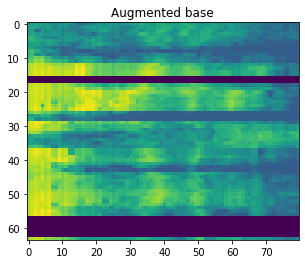

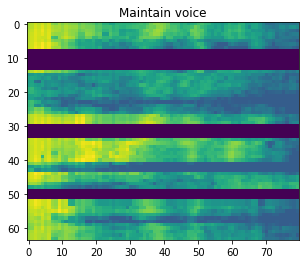

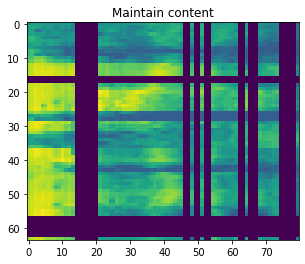

In [65]:
# See the impact of the augmentations

train_ds = tf.data.Dataset.from_tensor_slices((orig_data))
train_ds = train_ds
dataset = train_ds.shuffle(10000).map(get_augmentations, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

for i in dataset.take(1):
  man_vcs = i[0][0]
  man_cns = i[0][1]
  mains = i[1]    
  for (l1, l2, main) in zip(man_vcs, man_cns, mains):
    print(main.shape)
    plt.imshow(main)
    plt.title('Augmented base')
    plt.show()
    plt.imshow(l1)
    plt.title('Maintain voice')
    plt.show()
    plt.title('Maintain content')
    plt.imshow(l2)
    plt.show()
    break

# Autodecompose model build

In [63]:
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy, hinge, mse
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adadelta, Adagrad
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2, l1, l1_l2
import tensorflow as tf

embd_size_q = 128
embd_size_p = 128

def dense_batch(x, filt):
    x = layers.Dense(filt, activation='linear')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x

def conv1d_batch(x, filt, stride):
    x = layers.Conv1D(filt, stride, padding='same', activation='linear')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x

def get_large_encoder(x):
    x = get_conv1d_encoder(x)
    x = get_lstm_encoder(x)
    return x

def get_very_large_encoder(x):
    x = conv1d_batch(x, 1024, 5)
    x = conv1d_batch(x, 1024, 5)
    x = conv1d_batch(x, 1024, 5)
    x = layers.LSTM(1024, return_sequences=True)(x)
    x = layers.LSTM(1024, return_sequences=True)(x)
    x = layers.LSTM(1024, return_sequences=True)(x)

    return x

def get_lstm_encoder(x):
    x = layers.LSTM(256, return_sequences=True)(x)
    x = layers.LSTM(256, return_sequences=True)(x)
    x = layers.LSTM(256, return_sequences=True)(x)
    return x

def get_dense_encoder(x):
    x = dense_batch(x, 512)
    return x

def get_conv1d_encoder(x):
    x = conv1d_batch(x, 512, 5)
    x = conv1d_batch(x, 512, 5)
    x = conv1d_batch(x, 512, 5)
    return x

def bidirectional_encoder(x):
  x = conv1d_batch(x, 512, 5)
  x = conv1d_batch(x, 512, 5)
  x = conv1d_batch(x, 512, 5)

  x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
  x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
  x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)

  return x


def get_very_large_decoder(x):
  x = conv1d_batch(x, 1024, 5)
  x = conv1d_batch(x, 1024, 5)
  
  x = layers.LSTM(1024, return_sequences=True)(x)
  x = layers.LSTM(1024, return_sequences=True)(x)

  return x

def get_large_decoder(x):
  x = get_1d_decoder(x)
  x = get_lstm_decoder(x)

  return x

def get_1d_decoder(x):
  x = conv1d_batch(x, 512, 5)
  x = conv1d_batch(x, 512, 5)
  
  return x

def get_lstm_decoder(x):
  x = layers.LSTM(512, return_sequences=True)(x)  
  x = layers.LSTM(512, return_sequences=True)(x)  
  
  return x

def get_dense_decoder(x):
  x = layers.Dense(1024)(x) 
  # x = dense_batch(x, 1024)
  return x



candidate_encoders = {'large_encoder': get_large_encoder, 
                      'dense_encoder': get_dense_encoder, 
                      'conv1d_encoder': get_conv1d_encoder,
                      'lstm_encoder': get_lstm_encoder}

candidate_decoders = {'large_decoder': get_large_decoder, 
                      'conv1d_decoder': get_1d_decoder, 
                      'dense_decoder': get_dense_decoder,
                      'lstm_decoder': get_lstm_decoder}


def complete_encoder(inp_shapes, embd_size, name, bidirect=False):
    inputs = layers.Input(shape=inp_shapes, name='overall_inp')
    x = inputs

    x = selected_encoder(x)

    x = layers.Dense(embd_size)(x)

    model = Model(inputs, x, name=name)

    return model

def simple_decoder_builder(embed_size_p, embed_size_q, input_shape):
    input_p = layers.Input(shape=(input_shape[0], embed_size_p), name='input_p')
    input_q = layers.Input(shape=(input_shape[0], embed_size_q), name='input_q')

    inputs = layers.concatenate([input_p, input_q])

    x = inputs
    
    x = selected_decoder(x)

    x = layers.Dense(input_shape[1])(x)

    model = Model([input_p, input_q], x, name='decoder')
    return model

def full_complete_encoder(input_shape, embed_size_p, embed_size_q):
    input_p = layers.Input(shape=input_shape, name='inp_p')
    input_q = layers.Input(shape=input_shape, name='inp_q')

    encoder_p_model = complete_encoder(input_shape, embed_size_p, 'p_encoder', bidirect=False) 
    encoder_q_model = complete_encoder(input_shape, embed_size_q, 'q_encoder', bidirect=False) 
    decoder_model = simple_decoder_builder(embed_size_p, embed_size_q, input_shape)

    ep = encoder_p_model(input_p)
    eq = encoder_q_model(input_q)

    z_pq = decoder_model([ep, eq])
    optimizer = Adam()

    recons_model = Model([input_p, input_q], z_pq)
    recons_model.compile(optimizer=optimizer, loss='mse')

    return encoder_p_model, encoder_q_model, decoder_model, recons_model

selected_encoder = candidate_encoders['large_encoder']
selected_decoder = candidate_decoders['large_decoder']

time_samples = settings['len_crop'] # Number of samples in the time dimention of the mel
n_mel_channels = settings['mel_channels'] # Number of mel channels

input_shape = (time_samples, n_mel_channels)

encoder_p, encoder_q, decoder, recons_model = full_complete_encoder(input_shape, embd_size_p, embd_size_q)

encoder_p.summary()
recons_model.summary()


Model: "p_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 overall_inp (InputLayer)    [(None, 64, 80)]          0         
                                                                 
 conv1d_8 (Conv1D)           (None, 64, 512)           205312    
                                                                 
 batch_normalization_8 (Batc  (None, 64, 512)          2048      
 hNormalization)                                                 
                                                                 
 re_lu_8 (ReLU)              (None, 64, 512)           0         
                                                                 
 conv1d_9 (Conv1D)           (None, 64, 512)           1311232   
                                                                 
 batch_normalization_9 (Batc  (None, 64, 512)          2048      
 hNormalization)                                         

In [56]:
# Download pretrain models

!mkdir ./pretrained_models
# https://drive.google.com/file/d/1QbPV9H1UU0KXQnxQU9nPYTsuSewBxlla/view?usp=sharing
# https://drive.google.com/file/d/1pHfjO3dNkS7RnvE0Un-eLNkCw3KSa148/view?usp=sharing
!gdown 1QbPV9H1UU0KXQnxQU9nPYTsuSewBxlla -O ./pretrained_models/
!gdown 1pHfjO3dNkS7RnvE0Un-eLNkCw3KSa148 -O ./pretrained_models/

mkdir: cannot create directory ‘./pretrained_models’: File exists
Downloading...
From: https://drive.google.com/uc?id=1QbPV9H1UU0KXQnxQU9nPYTsuSewBxlla
To: /content/pretrained_models/model_s64_c64_s128_c128_libri_manipulateinput_no_overlap_256_256_500steps.h5
100% 188M/188M [00:00<00:00, 294MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pHfjO3dNkS7RnvE0Un-eLNkCw3KSa148
To: /content/pretrained_models/model_s64_c64_s128_c128_youtube_manipulateinput_no_overlap_256_256_500steps.h5
100% 188M/188M [00:00<00:00, 311MB/s]


In [61]:
# Pre-trained models

from tensorflow import keras
model_base_address = './pretrained_models'

recons_model = keras.models.load_model(''.join([model_base_address, '/model_s64_c64_s128_c128_youtube_manipulateinput_no_overlap_256_256_500steps.h5']))
# recons_model = keras.models.load_model(''.join([model_base_address, '/model_s64_c64_s128_c128_libri_manipulateinput_no_overlap_256_256_500steps.h5']))

encoder_p = recons_model.layers[2]
encoder_q = recons_model.layers[3]
recons_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp_p (InputLayer)             [(None, 64, 80)]     0           []                               
                                                                                                  
 inp_q (InputLayer)             [(None, 64, 80)]     0           []                               
                                                                                                  
 p_encoder (Functional)         (None, 64, 128)      4704896     ['inp_p[0][0]']                  
                                                                                                  
 q_encoder (Functional)         (None, 64, 128)      4704896     ['inp_q[0][0]']                  
                                                                                              

# Train and save results

Num people:  5
Epoch 1/10
94/94 [==============================] - 2s 10ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


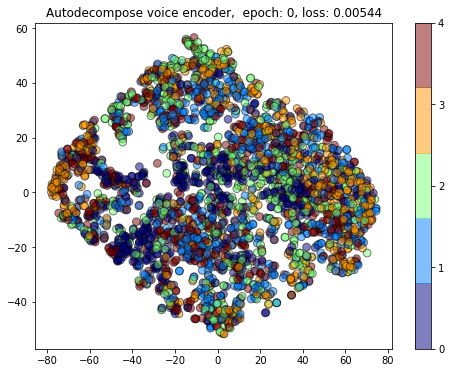

222/222 [==============================] - 64s 234ms/step - loss: 0.0054
Epoch 2/10
94/94 [==============================] - 1s 10ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


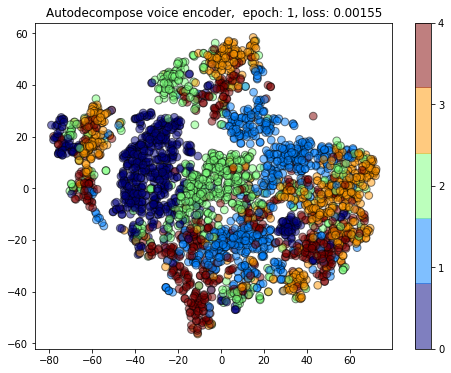

222/222 [==============================] - 50s 227ms/step - loss: 0.0015
Epoch 3/10
94/94 [==============================] - 1s 10ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


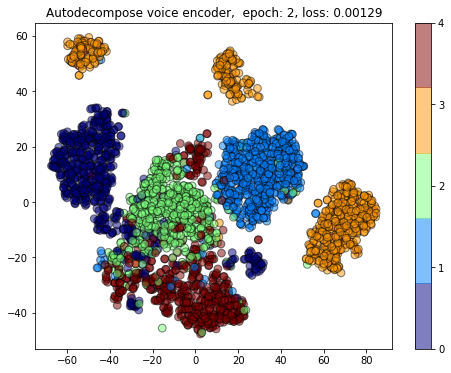

222/222 [==============================] - 50s 227ms/step - loss: 0.0013
Epoch 4/10
94/94 [==============================] - 1s 10ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


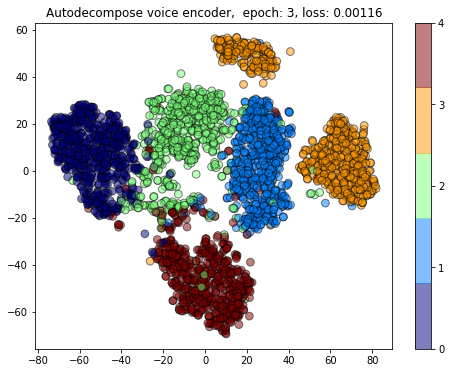

222/222 [==============================] - 50s 226ms/step - loss: 0.0012
Epoch 5/10
94/94 [==============================] - 1s 10ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


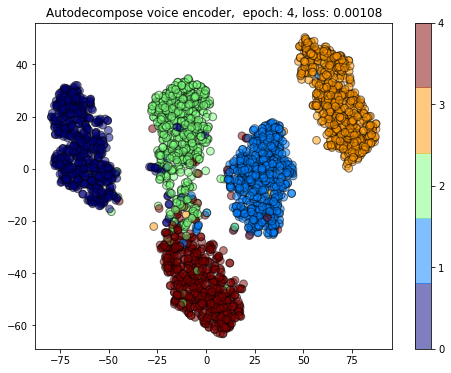

222/222 [==============================] - 50s 225ms/step - loss: 0.0011
Epoch 6/10
94/94 [==============================] - 1s 10ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


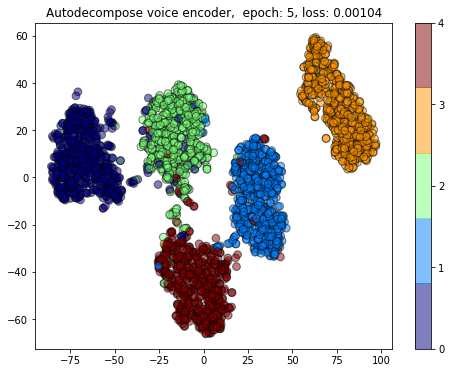

222/222 [==============================] - 50s 225ms/step - loss: 0.0010
Epoch 7/10
94/94 [==============================] - 1s 10ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


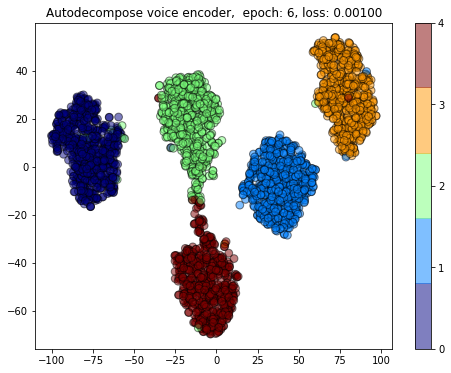

222/222 [==============================] - 50s 225ms/step - loss: 9.9775e-04
Epoch 8/10
94/94 [==============================] - 1s 10ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


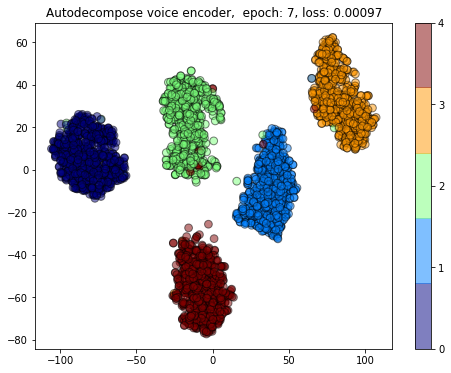

222/222 [==============================] - 50s 226ms/step - loss: 9.7484e-04
Epoch 9/10
94/94 [==============================] - 1s 10ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


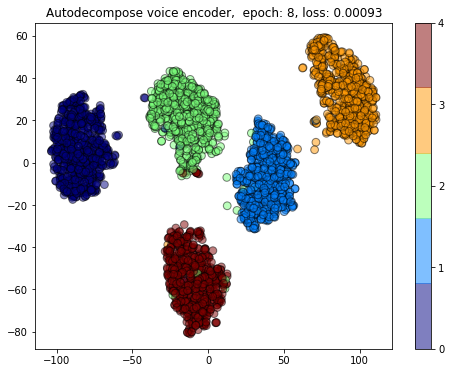

222/222 [==============================] - 50s 226ms/step - loss: 9.3388e-04
Epoch 10/10
94/94 [==============================] - 1s 10ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


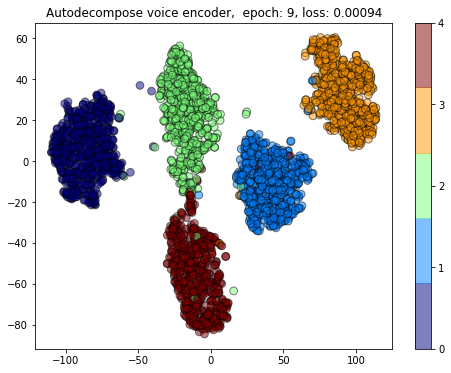

222/222 [==============================] - 50s 227ms/step - loss: 9.3756e-04


In [64]:
from tensorflow import keras
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns # '0.9.0'
import plotly.express as px

from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd

from sklearn.preprocessing import LabelEncoder

indexes_people = np.random.permutation(orig_data.shape[0])[:3000]
person_id_selected = person_id[indexes_people]

num_people = np.unique(person_id_selected).shape[0]

print('Num people: ', num_people)


def get_tsne_map_voice(p_embed, epoch, title, prev='pca', 
                       model_name='autodecompose_voice', save_image=False):
  tsne = TSNE(random_state=42, init=prev)
  plt.figure(figsize=(8, 6))

  embd_data = p_embed.reshape((p_embed.shape[0], p_embed.shape[1]*p_embed.shape[2]))
  tsne_embeds = tsne.fit_transform(embd_data)

  x = tsne_embeds[:, 0]
  y = tsne_embeds[:, 1]

  plt.scatter(x, y, c=person_id_selected,  s=60, cmap=plt.cm.get_cmap("jet", num_people),
              alpha=.5, linewidths=1, edgecolors='k', marker='o')
  plt.colorbar(ticks=range(num_people))

  plt.title(f'Autodecompose voice encoder, {title}')
  if save_image:
    folder_address = 'data/model_train_images/'
    plt.savefig(folder_address+model_name+"_"+str(epoch))
  
  plt.show()
  plt.close()
  return tsne_embeds

class EmbeddingEvaluationCallback(tf.keras.callbacks.Callback):
  voice_embd = 'pca'
  def on_epoch_end(self, epoch, logs=None):
    enc_p = self.model.layers[2]
    
    p_embed = enc_p.predict(orig_data[indexes_people])
    current_loss = logs.get("loss")

    self.voice_embd = get_tsne_map_voice(p_embed, epoch, 
                                    ''.join([' epoch: ', str(epoch), ', loss: ', "{:1.5f}".format(current_loss)]), 
                                    self.voice_embd, model_name='Autodecompose Voice Encoder')

train_ds = tf.data.Dataset.from_tensor_slices((orig_data))
train_ds = train_ds
dataset = train_ds.shuffle(10000).map(get_augmentations, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

history = recons_model.fit(dataset, epochs=10, callbacks=[EmbeddingEvaluationCallback()])


In [ ]:
# directory = '/content/drive/My Drive/results/mel_bottleneck_decompose/audio_results_test/pretrained_models/'
# if not os.path.exists(directory):
#     os.mkdir(directory)
# model_file_name = ''.join([directory, '/model_s64_c64_s128_c128_libri_manipulateinput_no_overlap_256_256_500steps.h5'])
# recons_model.save(model_file_name)